# Labo III
# Multinacional - Prediccion de Ventas

## Importamos librerias

In [16]:
# =============================================================================
# PARTE 1: LIBRERÍAS Y CONFIGURACIÓN INICIAL
# =============================================================================

# Librerías básicas para manipulación de datos
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Modelos de ensemble
import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

# Librerías para optimización y paralelización
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Configuración de reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configuración de paths (ajustar según tu estructura)
DATA_PATH = "../datasets/"
RESULTS_PATH = "../results/"

print("✅ Librerías importadas correctamente")
print(f"📊 Versión de pandas: {pd.__version__}")
print(f"🔢 Versión de numpy: {np.__version__}")
print(f"🌟 LightGBM disponible: {lgb.__version__}")
print(f"🚀 XGBoost disponible: {xgb.__version__}")
print(f"🎯 Random State configurado: {RANDOM_STATE}")

✅ Librerías importadas correctamente
📊 Versión de pandas: 2.2.3
🔢 Versión de numpy: 2.2.6
🌟 LightGBM disponible: 4.6.0
🚀 XGBoost disponible: 3.0.2
🎯 Random State configurado: 42


# funciones

In [17]:
# =============================================================================
# PARTE 2: FUNCIONES UTILITARIAS
# =============================================================================

def display_dataframe_info(df, name="DataFrame"):
    """
    Muestra información detallada sobre un DataFrame
    """
    print(f"\n{'='*50}")
    print(f"📊 INFORMACIÓN DE {name.upper()}")
    print(f"{'='*50}")
    print(f"🔹 Forma: {df.shape}")
    print(f"🔹 Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"🔹 Rango de fechas: {df['periodo'].min()} a {df['periodo'].max()}" if 'periodo' in df.columns else "")
    print(f"\n📋 Tipos de datos:")
    print(df.dtypes.value_counts())
    print(f"\n🔍 Valores nulos:")
    null_counts = df.isnull().sum()
    if null_counts.sum() > 0:
        print(null_counts[null_counts > 0])
    else:
        print("✅ No hay valores nulos")
    
    if 'tn' in df.columns:
        print(f"\n📈 Estadísticas de 'tn':")
        print(f"   • Total: {df['tn'].sum():.2f}")
        print(f"   • Promedio: {df['tn'].mean():.4f}")
        print(f"   • Mediana: {df['tn'].median():.4f}")
        print(f"   • Ceros: {(df['tn'] == 0).sum():,} ({(df['tn'] == 0).mean()*100:.1f}%)")

def validate_date_format(df, date_col='periodo'):
    """
    Valida y convierte formato de fecha
    """
    print(f"🕐 Validando formato de fecha en columna '{date_col}'...")
    
    if df[date_col].dtype == 'object':
        # Intentar convertir formato YYYYMM a datetime
        try:
            df[date_col] = pd.to_datetime(df[date_col], format='%Y%m')
            print("✅ Fecha convertida desde formato YYYYMM")
        except:
            try:
                df[date_col] = pd.to_datetime(df[date_col])
                print("✅ Fecha convertida con auto-detección")
            except:
                print("❌ Error al convertir fechas")
                return False
    
    print(f"📅 Rango de fechas: {df[date_col].min()} a {df[date_col].max()}")
    return True

def get_product_customer_lifecycles(sales_df):
    """
    Calcula los ciclos de vida de productos y clientes
    """
    print("🔍 Calculando ciclos de vida de productos y clientes...")
    
    # Ciclo de vida de productos
    product_lifecycle = sales_df.groupby('product_id')['periodo'].agg(['min', 'max']).reset_index()
    product_lifecycle.columns = ['product_id', 'product_first_sale', 'product_last_sale']
    
    # Ciclo de vida de clientes
    customer_lifecycle = sales_df.groupby('customer_id')['periodo'].agg(['min', 'max']).reset_index()
    customer_lifecycle.columns = ['customer_id', 'customer_first_purchase', 'customer_last_purchase']
    
    # Ciclo de vida de combinaciones producto-cliente
    product_customer_lifecycle = sales_df.groupby(['product_id', 'customer_id'])['periodo'].agg(['min', 'max']).reset_index()
    product_customer_lifecycle.columns = ['product_id', 'customer_id', 'first_purchase', 'last_purchase']
    
    print(f"✅ Productos únicos: {len(product_lifecycle):,}")
    print(f"✅ Clientes únicos: {len(customer_lifecycle):,}")
    print(f"✅ Combinaciones producto-cliente: {len(product_customer_lifecycle):,}")
    
    return product_lifecycle, customer_lifecycle, product_customer_lifecycle

def calculate_metrics(y_true, y_pred, model_name="Modelo"):
    """
    Calcula métricas de evaluación
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # Métrica de error porcentual personalizada
    error_percentage = np.abs(y_pred - y_true).sum() / y_true.sum() * 100
    
    metrics = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Error_Percentage': error_percentage
    }
    
    print(f"\n📊 MÉTRICAS DE {model_name.upper()}")
    print("-" * 40)
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    return metrics

def plot_predictions_vs_actual(y_true, y_pred, model_name="Modelo", sample_size=1000):
    """
    Grafica predicciones vs valores reales
    """
    # Tomar muestra si hay muchos datos
    if len(y_true) > sample_size:
        indices = np.random.choice(len(y_true), sample_size, replace=False)
        y_true_sample = y_true.iloc[indices] if hasattr(y_true, 'iloc') else y_true[indices]
        y_pred_sample = y_pred[indices]
    else:
        y_true_sample = y_true
        y_pred_sample = y_pred
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Scatter plot
    ax1.scatter(y_true_sample, y_pred_sample, alpha=0.6, s=30)
    max_val = max(y_true_sample.max(), y_pred_sample.max())
    ax1.plot([0, max_val], [0, max_val], 'r--', linewidth=2)
    ax1.set_xlabel('Valores Reales')
    ax1.set_ylabel('Valores Predichos')
    ax1.set_title(f'{model_name} - Predicho vs Real')
    ax1.grid(True, alpha=0.3)
    
    # Histograma de errores
    errors = y_pred_sample - y_true_sample
    ax2.hist(errors, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel('Error de Predicción')
    ax2.set_ylabel('Frecuencia')
    ax2.set_title(f'{model_name} - Distribución de Errores')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✅ Funciones utilitarias definidas correctamente")

✅ Funciones utilitarias definidas correctamente


## Importamos datasets

In [18]:
# =============================================================================
# PARTE 3: LECTURA Y CARGA DE DATASETS
# =============================================================================

def load_datasets(data_path="../datasets/"):
    """
    Carga todos los datasets necesarios
    """
    print("📂 Iniciando carga de datasets...")
    
    try:
        # Cargar datos de ventas (sell-in)
        print("🔄 Cargando datos de ventas (sell-in.txt)...")
        sales = pd.read_csv(f"{data_path}sell-in.txt", 
                           sep="\t", 
                           dtype={"periodo": str})
        
        # Cargar datos de stock
        print("🔄 Cargando datos de stock (tb_stocks.txt)...")
        stocks = pd.read_csv(f"{data_path}tb_stocks.txt", 
                            sep="\t", 
                            dtype={"periodo": str})
        
        # Cargar información de productos
        print("🔄 Cargando información de productos (tb_productos.txt)...")
        product_info = pd.read_csv(f"{data_path}tb_productos.txt", sep="\t")
        
        # Cargar productos a predecir
        print("🔄 Cargando productos a predecir (product_id_apredecir201912.txt)...")
        products_to_predict = pd.read_csv(f'{data_path}product_id_apredecir201912.txt')
        
        print("✅ Todos los datasets cargados correctamente")
        
        return sales, stocks, product_info, products_to_predict
        
    except FileNotFoundError as e:
        print(f"❌ Error: No se pudo encontrar el archivo {e}")
        return None, None, None, None
    except Exception as e:
        print(f"❌ Error al cargar datasets: {e}")
        return None, None, None, None

def preprocess_datasets(sales, stocks, product_info, products_to_predict):
    """
    Preprocesa los datasets básicos
    """
    print("\n🔧 Iniciando preprocesamiento de datasets...")
    
    # Convertir fechas
    print("📅 Convirtiendo formatos de fecha...")
    validate_date_format(sales, 'periodo')
    validate_date_format(stocks, 'periodo')
    
    # Mostrar información inicial
    display_dataframe_info(sales, "SALES (Original)")
    display_dataframe_info(stocks, "STOCKS")
    display_dataframe_info(product_info, "PRODUCT_INFO")
    
    # Verificar productos a predecir
    print(f"\n🎯 Productos a predecir: {len(products_to_predict):,}")
    if 'product_id' in products_to_predict.columns:
        predict_products_list = products_to_predict['product_id'].unique()
    else:
        # Si la columna tiene otro nombre, intentar la primera columna
        predict_products_list = products_to_predict.iloc[:, 0].unique()
    
    print(f"📋 Lista de productos a predecir (primeros 10): {predict_products_list[:10]}")
    
    # Validar que los productos a predecir estén en los datos históricos
    products_in_sales = sales['product_id'].unique()
    missing_products = set(predict_products_list) - set(products_in_sales)
    
    if missing_products:
        print(f"⚠️  Productos a predecir que NO están en ventas históricas: {len(missing_products)}")
        print(f"    Ejemplos: {list(missing_products)[:5]}")
    else:
        print("✅ Todos los productos a predecir tienen datos históricos")
    
    # Agregar información de productos a ventas
    print("🔗 Fusionando información de productos con ventas...")
    sales_with_info = sales.merge(product_info, on='product_id', how='left')
    
    # Verificar merge
    sales_without_info = sales_with_info[sales_with_info['cat1'].isnull()]
    if len(sales_without_info) > 0:
        print(f"⚠️  Ventas sin información de producto: {len(sales_without_info):,}")
        print(f"    Productos únicos sin info: {sales_without_info['product_id'].nunique()}")
    else:
        print("✅ Todas las ventas tienen información de producto")
    
    # Agregar stocks a ventas
    print("🔗 Fusionando información de stocks con ventas...")
    sales_complete = sales_with_info.merge(stocks, on=['periodo', 'product_id'], how='left')
    
    # Mostrar resultado final
    display_dataframe_info(sales_complete, "SALES (Completo)")
    
    return sales_complete, predict_products_list

# Ejecutar carga de datos
print("🚀 INICIANDO CARGA Y PREPROCESAMIENTO DE DATOS")
print("=" * 60)

# Cargar datasets
sales, stocks, product_info, products_to_predict = load_datasets()

if sales is not None:
    # Preprocesar datasets
    sales_complete, predict_products_list = preprocess_datasets(sales, stocks, product_info, products_to_predict)
    
    print(f"\n🎉 CARGA COMPLETADA EXITOSAMENTE")
    print(f"📊 Dataset final: {sales_complete.shape[0]:,} registros")
    print(f"🎯 Productos a predecir: {len(predict_products_list):,}")
    print(f"📅 Rango temporal: {sales_complete['periodo'].min()} a {sales_complete['periodo'].max()}")
else:
    print("❌ Error en la carga de datos. Verificar paths y archivos.")

🚀 INICIANDO CARGA Y PREPROCESAMIENTO DE DATOS
📂 Iniciando carga de datasets...
🔄 Cargando datos de ventas (sell-in.txt)...
🔄 Cargando datos de stock (tb_stocks.txt)...
🔄 Cargando información de productos (tb_productos.txt)...
🔄 Cargando productos a predecir (product_id_apredecir201912.txt)...
✅ Todos los datasets cargados correctamente

🔧 Iniciando preprocesamiento de datasets...
📅 Convirtiendo formatos de fecha...
🕐 Validando formato de fecha en columna 'periodo'...
✅ Fecha convertida desde formato YYYYMM
📅 Rango de fechas: 2017-01-01 00:00:00 a 2019-12-01 00:00:00
🕐 Validando formato de fecha en columna 'periodo'...
✅ Fecha convertida desde formato YYYYMM
📅 Rango de fechas: 2018-10-01 00:00:00 a 2019-12-01 00:00:00

📊 INFORMACIÓN DE SALES (ORIGINAL)
🔹 Forma: (2945818, 7)
🔹 Memoria utilizada: 157.32 MB
🔹 Rango de fechas: 2017-01-01 00:00:00 a 2019-12-01 00:00:00

📋 Tipos de datos:
int64             4
float64           2
datetime64[ns]    1
Name: count, dtype: int64

🔍 Valores nulos:
✅

# Dealing with zeros

In [19]:
# =============================================================================
# PARTE 4: AGREGADO DE CEROS (LÓGICA COMPLEJA)
# =============================================================================

def create_zero_transactions(sales_df, verbose=True):
    """
    Crea transacciones con tn=0 siguiendo la lógica compleja de ciclos de vida
    
    Lógica:
    - Un producto existe desde su primera venta hasta su última venta
    - Un cliente existe desde su primera compra hasta su última compra  
    - Para cada combinación <product_id, customer_id> que esté "viva" en un período,
      si no existe transacción, se inserta una con tn=0
    """
    print("🔧 INICIANDO PROCESO DE AGREGADO DE CEROS")
    print("=" * 60)
    
    # Paso 1: Calcular ciclos de vida
    if verbose:
        print("📊 Calculando ciclos de vida...")
    
    # Ciclo de vida de productos (primera a última venta)
    product_lifecycle = sales_df.groupby('product_id')['periodo'].agg(['min', 'max']).reset_index()
    product_lifecycle.columns = ['product_id', 'product_start', 'product_end']
    
    # Ciclo de vida de clientes (primera a última compra)
    customer_lifecycle = sales_df.groupby('customer_id')['periodo'].agg(['min', 'max']).reset_index()
    customer_lifecycle.columns = ['customer_id', 'customer_start', 'customer_end']
    
    if verbose:
        print(f"   • Productos únicos: {len(product_lifecycle):,}")
        print(f"   • Clientes únicos: {len(customer_lifecycle):,}")
        print(f"   • Rango temporal: {sales_df['periodo'].min()} a {sales_df['periodo'].max()}")
    
    # Paso 2: Crear grid completo de períodos
    all_periods = pd.date_range(
        start=sales_df['periodo'].min(),
        end=sales_df['periodo'].max(),
        freq='MS'  # Month Start frequency
    )
    
    if verbose:
        print(f"   • Períodos totales: {len(all_periods)}")
    
    # Paso 3: Determinar combinaciones válidas por período
    print("🔄 Generando combinaciones válidas producto-cliente por período...")
    
    valid_combinations = []
    
    for period in tqdm(all_periods, desc="Procesando períodos"):
        # Productos vivos en este período
        active_products = product_lifecycle[
            (product_lifecycle['product_start'] <= period) & 
            (product_lifecycle['product_end'] >= period)
        ]['product_id'].values
        
        # Clientes vivos en este período  
        active_customers = customer_lifecycle[
            (customer_lifecycle['customer_start'] <= period) & 
            (customer_lifecycle['customer_end'] >= period)
        ]['customer_id'].values
        
        # Crear todas las combinaciones válidas para este período
        if len(active_products) > 0 and len(active_customers) > 0:
            period_combinations = pd.DataFrame({
                'periodo': period,
                'product_id': np.repeat(active_products, len(active_customers)),
                'customer_id': np.tile(active_customers, len(active_products))
            })
            valid_combinations.append(period_combinations)
    
    # Combinar todas las combinaciones
    print("🔗 Combinando todas las combinaciones válidas...")
    all_valid_combinations = pd.concat(valid_combinations, ignore_index=True)
    
    if verbose:
        print(f"   • Combinaciones teóricas totales: {len(all_valid_combinations):,}")
    
    # Paso 4: Identificar transacciones existentes
    print("🔍 Identificando transacciones existentes...")
    existing_transactions = sales_df[['periodo', 'product_id', 'customer_id']].copy()
    existing_transactions['exists'] = True
    
    # Paso 5: Encontrar combinaciones faltantes (que necesitan tn=0)
    print("❌ Identificando transacciones faltantes...")
    complete_grid = all_valid_combinations.merge(
        existing_transactions,
        on=['periodo', 'product_id', 'customer_id'],
        how='left'
    )
    
    missing_transactions = complete_grid[complete_grid['exists'].isnull()].copy()
    missing_transactions = missing_transactions.drop('exists', axis=1)
    
    if verbose:
        print(f"   • Transacciones existentes: {len(existing_transactions):,}")
        print(f"   • Transacciones faltantes: {len(missing_transactions):,}")
        print(f"   • Factor de multiplicación: {len(complete_grid) / len(existing_transactions):.2f}x")
    
    # Paso 6: Crear transacciones con tn=0
    print("➕ Creando transacciones con tn=0...")
    
    # Agregar columnas faltantes con valores por defecto
    missing_transactions['tn'] = 0.0
    missing_transactions['plan_precios_cuidados'] = 0
    missing_transactions['cust_request_qty'] = 0
    missing_transactions['cust_request_tn'] = 0.0
    
    # Agregar información de productos (merge con product_info)
    print("🔗 Agregando información de productos a transacciones faltantes...")
    
    # Obtener product_info del dataset original
    product_cols = ['product_id', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'descripcion']
    product_info_unique = sales_df[product_cols].drop_duplicates()
    
    missing_transactions = missing_transactions.merge(
        product_info_unique,
        on='product_id',
        how='left'
    )
    
    # Agregar stock_final como NaN (se manejará después)
    missing_transactions['stock_final'] = np.nan
    
    # Paso 7: Combinar transacciones originales con las nuevas
    print("🔄 Combinando transacciones originales con las nuevas...")
    
    # Asegurar que las columnas estén en el mismo orden
    columns_order = sales_df.columns.tolist()
    missing_transactions = missing_transactions[columns_order]
    
    # Combinar datasets
    complete_sales = pd.concat([sales_df, missing_transactions], ignore_index=True)
    
    # Ordenar por período, producto y cliente
    complete_sales = complete_sales.sort_values(['periodo', 'product_id', 'customer_id'])
    
    if verbose:
        print("\n📊 RESULTADO FINAL:")
        print(f"   • Registros originales: {len(sales_df):,}")
        print(f"   • Registros agregados (tn=0): {len(missing_transactions):,}")
        print(f"   • Total final: {len(complete_sales):,}")
        print(f"   • Factor de crecimiento: {len(complete_sales) / len(sales_df):.2f}x")
        print(f"   • Porcentaje de ceros: {(complete_sales['tn'] == 0).mean() * 100:.1f}%")
    
    return complete_sales, missing_transactions

def validate_zero_insertion(complete_sales, original_sales, verbose=True):
    """
    Valida que el proceso de inserción de ceros sea correcto
    """
    print("\n🔍 VALIDANDO INSERCIÓN DE CEROS")
    print("-" * 40)
    
    # Verificar que no se perdieron transacciones originales
    original_sum = original_sales['tn'].sum()
    new_sum = complete_sales[complete_sales['tn'] > 0]['tn'].sum()
    
    if abs(original_sum - new_sum) < 0.01:  # Pequeña tolerancia por precisión float
        print("✅ Suma de ventas originales preservada")
    else:
        print(f"❌ ERROR: Suma original: {original_sum:.2f}, Nueva suma: {new_sum:.2f}")
    
    # Verificar estructura temporal
    periods_original = set(original_sales['periodo'].unique())
    periods_new = set(complete_sales['periodo'].unique())
    
    if periods_original == periods_new:
        print("✅ Períodos temporales preservados")
    else:
        print(f"❌ ERROR: Períodos diferentes")
    
    # Estadísticas de ceros
    zero_count = (complete_sales['tn'] == 0).sum()
    total_count = len(complete_sales)
    zero_percentage = (zero_count / total_count) * 100
    
    print(f"📊 Registros con tn=0: {zero_count:,} ({zero_percentage:.1f}%)")
    print(f"📊 Registros con tn>0: {total_count - zero_count:,} ({100-zero_percentage:.1f}%)")
    
    if verbose:
        display_dataframe_info(complete_sales, "SALES (Con Ceros)")
    
    return True

# Ejecutar proceso de agregado de ceros
print("🚀 EJECUTANDO AGREGADO DE CEROS")
print("⚠️  ADVERTENCIA: Este proceso puede tomar varios minutos...")
print("📊 Dataset inicial:", sales_complete.shape)

# Ejecutar el proceso
complete_sales_with_zeros, added_zero_transactions = create_zero_transactions(
    sales_complete, 
    verbose=True
)

# Validar el resultado
validate_zero_insertion(complete_sales_with_zeros, sales_complete, verbose=True)

print("\n🎉 PROCESO DE AGREGADO DE CEROS COMPLETADO")
print(f"📈 Crecimiento: {sales_complete.shape[0]:,} → {complete_sales_with_zeros.shape[0]:,}")

🚀 EJECUTANDO AGREGADO DE CEROS
⚠️  ADVERTENCIA: Este proceso puede tomar varios minutos...
📊 Dataset inicial: (2945818, 14)
🔧 INICIANDO PROCESO DE AGREGADO DE CEROS
📊 Calculando ciclos de vida...
   • Productos únicos: 1,233
   • Clientes únicos: 597
   • Rango temporal: 2017-01-01 00:00:00 a 2019-12-01 00:00:00
   • Períodos totales: 36
🔄 Generando combinaciones válidas producto-cliente por período...


Procesando períodos: 100%|██████████| 36/36 [00:00<00:00, 71.44it/s]


🔗 Combinando todas las combinaciones válidas...
   • Combinaciones teóricas totales: 15,563,113
🔍 Identificando transacciones existentes...
❌ Identificando transacciones faltantes...
   • Transacciones existentes: 2,945,818
   • Transacciones faltantes: 12,617,295
   • Factor de multiplicación: 5.28x
➕ Creando transacciones con tn=0...
🔗 Agregando información de productos a transacciones faltantes...
🔄 Combinando transacciones originales con las nuevas...

📊 RESULTADO FINAL:
   • Registros originales: 2,945,818
   • Registros agregados (tn=0): 12,617,295
   • Total final: 15,563,113
   • Factor de crecimiento: 5.28x
   • Porcentaje de ceros: 81.1%

🔍 VALIDANDO INSERCIÓN DE CEROS
----------------------------------------
✅ Suma de ventas originales preservada
✅ Períodos temporales preservados
📊 Registros con tn=0: 12,617,295 (81.1%)
📊 Registros con tn>0: 2,945,818 (18.9%)

📊 INFORMACIÓN DE SALES (CON CEROS)
🔹 Forma: (15563113, 14)
🔹 Memoria utilizada: 5361.00 MB
🔹 Rango de fechas: 2017-0

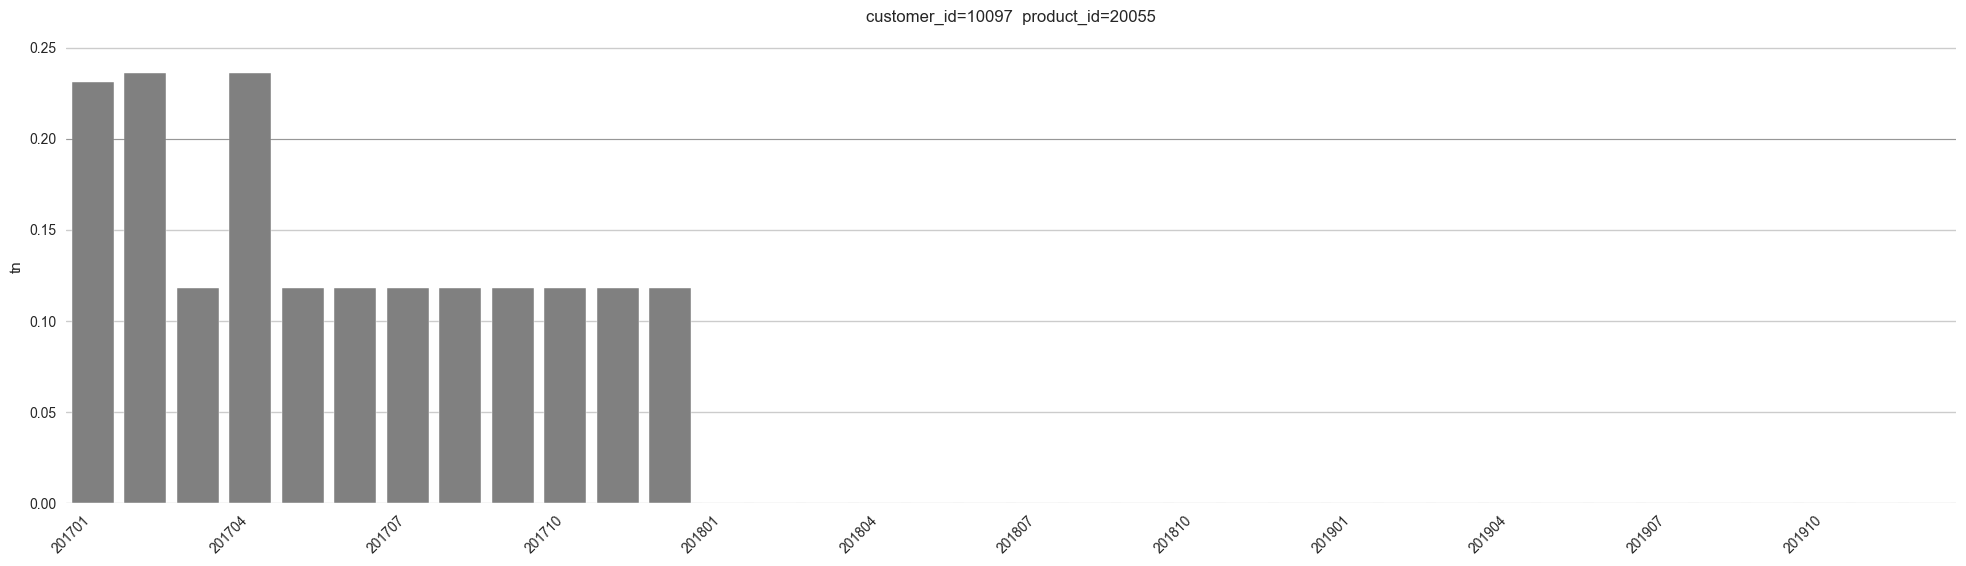

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.dates import MonthLocator, DateFormatter
import matplotlib.patches as mpatches

def create_improved_sales_chart(complete_sales_with_zeros, customer_id, product_id):
    """
    Crea un gráfico mejorado para analizar las ventas de un cliente-producto específico
    """
    # Filtrar datos
    filtered_df = complete_sales_with_zeros[
        (complete_sales_with_zeros['customer_id'] == customer_id) & 
        (complete_sales_with_zeros['product_id'] == product_id)
    ].copy()
    
    # Asegurar que 'periodo' sea datetime
    filtered_df['periodo'] = pd.to_datetime(filtered_df['periodo'])
    filtered_df = filtered_df.sort_values('periodo')
    
    # Obtener información adicional del producto
    product_info = filtered_df[['cat1', 'cat2', 'brand', 'descripcion']].iloc[0]
    
    # Configurar el estilo
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(20, 8))
    
    # Crear colores diferenciados para ventas reales vs ceros
    colors = ['#2E86AB' if tn > 0 else '#F24236' for tn in filtered_df['tn']]
    
    # Crear el gráfico de barras
    bars = ax.bar(filtered_df['periodo'], filtered_df['tn'], 
                  color=colors, alpha=0.8, width=20)  # width en días
    
    # Personalizar el gráfico
    ax.set_title(f'Análisis de Ventas - Cliente {customer_id} | Producto {product_id}\n'
                f'{product_info["brand"]} | {product_info["cat1"]} > {product_info["cat2"]}\n'
                f'{product_info["descripcion"][:80]}{"..." if len(product_info["descripcion"]) > 80 else ""}', 
                fontsize=14, fontweight='bold', pad=20)
    
    # Configurar eje X
    ax.set_xlabel('Período', fontsize=12, fontweight='bold')
    
    # Formato de fechas en X
    ax.xaxis.set_major_locator(MonthLocator(interval=3))  # Cada 3 meses
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    ax.xaxis.set_minor_locator(MonthLocator())  # Marcas menores cada mes
    
    # Rotar etiquetas del eje X
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Configurar eje Y
    ax.set_ylabel('Ventas (tn)', fontsize=12, fontweight='bold')
    
    # Mejorar el grid
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Establecer límites del eje Y
    y_max = filtered_df['tn'].max()
    if y_max > 0:
        ax.set_ylim(0, y_max * 1.1)
    else:
        ax.set_ylim(0, 0.1)
    
    # Agregar líneas de referencia horizontales
    if y_max > 0:
        for y in np.arange(0.05, y_max * 1.1, 0.05):
            ax.axhline(y=y, color='gray', linestyle='-', alpha=0.2, linewidth=0.5)
    
    # Crear leyenda
    venta_patch = mpatches.Patch(color='#2E86AB', label='Ventas > 0')
    cero_patch = mpatches.Patch(color='#F24236', label='Ventas = 0')
    ax.legend(handles=[venta_patch, cero_patch], loc='upper right', 
              frameon=True, fancybox=True, shadow=True)
    
    # Agregar estadísticas como texto
    total_periods = len(filtered_df)
    periods_with_sales = (filtered_df['tn'] > 0).sum()
    periods_zero = total_periods - periods_with_sales
    total_sales = filtered_df['tn'].sum()
    avg_sales = filtered_df[filtered_df['tn'] > 0]['tn'].mean() if periods_with_sales > 0 else 0
    
    stats_text = f"""Estadísticas del Período:
• Total períodos: {total_periods}
• Períodos con ventas: {periods_with_sales} ({periods_with_sales/total_periods*100:.1f}%)
• Períodos sin ventas: {periods_zero} ({periods_zero/total_periods*100:.1f}%)
• Ventas totales: {total_sales:.3f} tn
• Promedio (períodos con venta): {avg_sales:.3f} tn"""
    
    # Posicionar el texto de estadísticas
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Resaltar el período de mayor venta
    if y_max > 0:
        max_idx = filtered_df['tn'].idxmax()
        max_period = filtered_df.loc[max_idx, 'periodo']
        max_value = filtered_df.loc[max_idx, 'tn']
        
        # Agregar anotación para el máximo
        ax.annotate(f'Máximo: {max_value:.3f} tn\n{max_period.strftime("%Y-%m")}',
                   xy=(max_period, max_value), xytext=(10, 10),
                   textcoords='offset points', fontsize=9,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # Agregar información sobre el ciclo de vida
    first_period = filtered_df['periodo'].min()
    last_period = filtered_df['periodo'].max()
    
    # Líneas verticales para marcar inicio y fin del ciclo
    ax.axvline(x=first_period, color='green', linestyle='--', alpha=0.7, linewidth=2)
    ax.axvline(x=last_period, color='red', linestyle='--', alpha=0.7, linewidth=2)
    
    # Etiquetas para las líneas
    ax.text(first_period, ax.get_ylim()[1] * 0.9, 'Inicio Ciclo', 
            rotation=90, va='top', ha='right', color='green', fontweight='bold')
    ax.text(last_period, ax.get_ylim()[1] * 0.9, 'Fin Ciclo', 
            rotation=90, va='top', ha='left', color='red', fontweight='bold')
    
    # Ajustar márgenes
    plt.tight_layout()
    
    # Mostrar el gráfico
    plt.show()
    
    return fig, ax

# Ejemplo de uso:
customer_id = 10097
product_id = 20055

# Llamar a la función mejorada
fig, ax = create_improved_sales_chart(complete_sales_with_zeros, customer_id, product_id)

# Opción adicional: Crear gráfico de líneas para ver la tendencia
def create_trend_chart(complete_sales_with_zeros, customer_id, product_id):
    """
    Crea un gráfico de líneas complementario para ver tendencias
    """
    filtered_df = complete_sales_with_zeros[
        (complete_sales_with_zeros['customer_id'] == customer_id) & 
        (complete_sales_with_zeros['product_id'] == product_id)
    ].copy()
    
    filtered_df['periodo'] = pd.to_datetime(filtered_df['periodo'])
    filtered_df = filtered_df.sort_values('periodo')
    
    fig, ax = plt.subplots(figsize=(20, 6))
    
    # Línea principal
    ax.plot(filtered_df['periodo'], filtered_df['tn'], 
            marker='o', linewidth=2, markersize=4, color='#2E86AB')
    
    # Resaltar puntos con ventas > 0
    sales_points = filtered_df[filtered_df['tn'] > 0]
    if len(sales_points) > 0:
        ax.scatter(sales_points['periodo'], sales_points['tn'], 
                  color='#F24236', s=50, zorder=5, alpha=0.8)
    
    # Área bajo la curva
    ax.fill_between(filtered_df['periodo'], filtered_df['tn'], 
                   alpha=0.3, color='#2E86AB')
    
    ax.set_title(f'Tendencia de Ventas - Cliente {customer_id} | Producto {product_id}', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Período', fontsize=12)
    ax.set_ylabel('Ventas (tn)', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Formato de fechas
    ax.xaxis.set_major_locator(MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

# Crear también el gráfico de tendencia
fig_trend, ax_trend = create_trend_chart(complete_sales_with_zeros, customer_id, product_id)

# FE

In [24]:
# =============================================================================
# PARTE 5: FEATURE ENGINEERING
# =============================================================================

def create_temporal_features(df):
    """
    Crea características temporales a partir de la fecha
    """
    print("📅 Creando características temporales...")
    
    df = df.copy()
    
    # Características básicas de tiempo
    df['year'] = df['periodo'].dt.year
    df['month'] = df['periodo'].dt.month
    df['quarter'] = df['periodo'].dt.quarter
    df['is_december'] = (df['month'] == 12).astype(int)
    df['is_january'] = (df['month'] == 1).astype(int)
    
    # Tiempo transcurrido desde inicio
    min_date = df['periodo'].min()
    df['months_since_start'] = ((df['periodo'] - min_date).dt.days / 30.44).astype(int)
    
    # Características cíclicas (para capturar estacionalidad)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)
    
    print(f"   ✅ Características temporales creadas")
    return df

def create_lag_features(df, target_col='tn', lags=[1, 2, 3, 6, 12]):
    """
    Crea características de lag (valores anteriores) por producto-cliente
    """
    print(f"⏱️ Creando características de lag para {target_col}...")
    
    df = df.copy()
    df = df.sort_values(['product_id', 'customer_id', 'periodo'])
    
    for lag in lags:
        lag_col = f'{target_col}_lag_{lag}'
        df[lag_col] = df.groupby(['product_id', 'customer_id'])[target_col].shift(lag)
        print(f"   • Lag {lag}: {lag_col}")
    
    print(f"   ✅ {len(lags)} características de lag creadas")
    return df

def create_rolling_features(df, target_col='tn', windows=[3, 6, 12]):
    """
    Crea características de ventanas móviles
    """
    print(f"📊 Creando características de ventanas móviles para {target_col}...")
    
    df = df.copy()
    df = df.sort_values(['product_id', 'customer_id', 'periodo'])
    
    for window in windows:
        # Media móvil
        col_mean = f'{target_col}_rolling_mean_{window}'
        df[col_mean] = df.groupby(['product_id', 'customer_id'])[target_col].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
        )
        
        # Desviación estándar móvil
        col_std = f'{target_col}_rolling_std_{window}'
        df[col_std] = df.groupby(['product_id', 'customer_id'])[target_col].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).std()
        )
        
        # Máximo móvil
        col_max = f'{target_col}_rolling_max_{window}'
        df[col_max] = df.groupby(['product_id', 'customer_id'])[target_col].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).max()
        )
        
        print(f"   • Ventana {window}: mean, std, max")
    
    print(f"   ✅ {len(windows) * 3} características de ventanas móviles creadas")
    return df

def create_aggregated_features(df):
    """
    Crea características agregadas por producto, cliente y combinaciones
    """
    print("🎯 Creando características agregadas...")
    
    df = df.copy()
    
    # Características por producto (usando solo datos históricos)
    print("   • Agregaciones por producto...")
    product_stats = df.groupby('product_id')['tn'].agg([
        'mean', 'std', 'median', 'sum', 'count'
    ]).reset_index()
    product_stats.columns = ['product_id'] + [f'product_{col}' for col in product_stats.columns[1:]]
    
    # Características por cliente
    print("   • Agregaciones por cliente...")
    customer_stats = df.groupby('customer_id')['tn'].agg([
        'mean', 'std', 'median', 'sum', 'count'
    ]).reset_index()
    customer_stats.columns = ['customer_id'] + [f'customer_{col}' for col in customer_stats.columns[1:]]
    
    # Características por combinación producto-cliente
    print("   • Agregaciones por producto-cliente...")
    product_customer_stats = df.groupby(['product_id', 'customer_id'])['tn'].agg([
        'mean', 'std', 'median', 'sum', 'count'
    ]).reset_index()
    product_customer_stats.columns = ['product_id', 'customer_id'] + [f'prod_cust_{col}' for col in product_customer_stats.columns[2:]]
    
    # Merge con dataset principal
    df = df.merge(product_stats, on='product_id', how='left')
    df = df.merge(customer_stats, on='customer_id', how='left')
    df = df.merge(product_customer_stats, on=['product_id', 'customer_id'], how='left')
    
    print(f"   ✅ Características agregadas creadas")
    return df

def create_interaction_features(df):
    """
    Crea características de interacción y ratios
    """
    print("🔄 Creando características de interacción...")
    
    df = df.copy()
    
    # Ratios de tamaño de producto vs promedios
    if 'sku_size' in df.columns and 'product_mean' in df.columns:
        df['sku_size_vs_product_mean'] = df['sku_size'] / (df['product_mean'] + 1e-8)
    
    # Interacción mes-marca
    if 'brand' in df.columns:
        df['brand_month'] = df['brand'].astype(str) + '_' + df['month'].astype(str)
    
    # Ratio de stock vs demanda histórica
    if 'stock_final' in df.columns and 'product_mean' in df.columns:
        df['stock_vs_demand_ratio'] = df['stock_final'] / (df['product_mean'] + 1e-8)
    
    # Tendencia reciente vs histórica
    if 'tn_rolling_mean_3' in df.columns and 'product_mean' in df.columns:
        df['recent_vs_historical'] = df['tn_rolling_mean_3'] / (df['product_mean'] + 1e-8)
    
    print(f"   ✅ Características de interacción creadas")
    return df

def handle_missing_values(df):
    """
    Maneja valores faltantes en características
    """
    print("🔧 Manejando valores faltantes...")
    
    df = df.copy()
    
    # Llenar NaN en características de lag y rolling con 0 o estadísticas del grupo
    lag_cols = [col for col in df.columns if 'lag_' in col or 'rolling_' in col]
    
    for col in lag_cols:
        if df[col].isnull().sum() > 0:
            # Rellenar con 0 para lags y con la media del producto para rolling
            if 'rolling_mean' in col:
                df[col] = df.groupby('product_id')[col].transform(lambda x: x.fillna(x.mean()))
            else:
                df[col] = df[col].fillna(0)
    
    # Llenar NaN en stock_final con 0
    if 'stock_final' in df.columns:
        df['stock_final'] = df['stock_final'].fillna(0)
    
    # Llenar NaN en características categóricas
    categorical_cols = ['cat1', 'cat2', 'cat3', 'brand', 'descripcion']
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].fillna('Unknown')
    
    # Llenar NaN en características numéricas restantes con 0
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(0)
    
    print(f"   ✅ Valores faltantes manejados")
    return df

def create_all_features(df):
    """
    Ejecuta todo el pipeline de feature engineering
    """
    print("\n🔧 INICIANDO FEATURE ENGINEERING COMPLETO")
    print("=" * 50)
    
    original_shape = df.shape
    print(f"📊 Shape inicial: {original_shape}")
    
    # Aplicar todas las transformaciones
    df = create_temporal_features(df)
    df = create_lag_features(df)
    df = create_rolling_features(df)
    df = create_aggregated_features(df)
    df = create_interaction_features(df)
    df = handle_missing_values(df)
    
    final_shape = df.shape
    print(f"\n📊 Shape final: {final_shape}")
    print(f"🎯 Características agregadas: {final_shape[1] - original_shape[1]}")
    
    # Mostrar información de las nuevas características
    new_features = [col for col in df.columns if col not in ['periodo', 'customer_id', 'product_id', 'tn', 'plan_precios_cuidados', 'cust_request_qty', 'cust_request_tn']]
    print(f"\n📋 Características disponibles para modelado: {len(new_features)}")
    
    # Separar por tipo
    temporal_features = [col for col in new_features if any(x in col for x in ['year', 'month', 'quarter', 'sin', 'cos', 'since_start'])]
    lag_features = [col for col in new_features if 'lag_' in col]
    rolling_features = [col for col in new_features if 'rolling_' in col]
    agg_features = [col for col in new_features if any(x in col for x in ['product_', 'customer_', 'prod_cust_'])]
    categorical_features = [col for col in new_features if col in ['cat1', 'cat2', 'cat3', 'brand', 'brand_month']]
    other_features = [col for col in new_features if col not in temporal_features + lag_features + rolling_features + agg_features + categorical_features]
    
    print(f"   • Temporales: {len(temporal_features)}")
    print(f"   • Lag: {len(lag_features)}")
    print(f"   • Rolling: {len(rolling_features)}")
    print(f"   • Agregadas: {len(agg_features)}")
    print(f"   • Categóricas: {len(categorical_features)}")
    print(f"   • Otras: {len(other_features)}")
    
    return df, {
        'temporal': temporal_features,
        'lag': lag_features,
        'rolling': rolling_features,
        'aggregated': agg_features,
        'categorical': categorical_features,
        'other': other_features,
        'all': new_features
    }

# Ejecutar feature engineering
print("🚀 EJECUTANDO FEATURE ENGINEERING")
print("⚠️  ADVERTENCIA: Este proceso puede tomar varios minutos...")

# Aplicar feature engineering
sales_with_features, feature_groups = create_all_features(complete_sales_with_zeros)

# Mostrar resultado final
display_dataframe_info(sales_with_features, "SALES (Con Features)")

print("\n🎉 FEATURE ENGINEERING COMPLETADO")
print(f"📊 Dataset final: {sales_with_features.shape}")

🚀 EJECUTANDO FEATURE ENGINEERING
⚠️  ADVERTENCIA: Este proceso puede tomar varios minutos...

🔧 INICIANDO FEATURE ENGINEERING COMPLETO
📊 Shape inicial: (15563113, 14)
📅 Creando características temporales...
   ✅ Características temporales creadas
⏱️ Creando características de lag para tn...
   • Lag 1: tn_lag_1
   • Lag 2: tn_lag_2
   • Lag 3: tn_lag_3
   • Lag 6: tn_lag_6
   • Lag 12: tn_lag_12
   ✅ 5 características de lag creadas
📊 Creando características de ventanas móviles para tn...
   • Ventana 3: mean, std, max
   • Ventana 6: mean, std, max
   • Ventana 12: mean, std, max
   ✅ 9 características de ventanas móviles creadas
🎯 Creando características agregadas...
   • Agregaciones por producto...
   • Agregaciones por cliente...
   • Agregaciones por producto-cliente...
   ✅ Características agregadas creadas
🔄 Creando características de interacción...
   ✅ Características de interacción creadas
🔧 Manejando valores faltantes...


MemoryError: Unable to allocate 4.29 GiB for an array with shape (37, 15563113) and data type float64

# LIGHTGBM

Calcular o simular una prediccion para el 201912 con los datos del 201910 para generar una curva de pred vs real para ver como performa mi modelo

Forma de X_train: (28634, 14)
Forma de X_val: (955, 14)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3287
[LightGBM] [Info] Number of data points in the train set: 28634, number of used features: 953
[LightGBM] [Info] Start training from score 45.176667


C:\Users\s1093678\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Forma de predictions: (955, 2)
Primeras filas de predictions:
   product_id           tn
0       20001  1221.201051
1       20002  1012.338596
2       20003   759.223555
3       20004   678.215168
4       20005   638.129599
Error (Suma de errores absolutos / Suma de valores reales): 0.3452
Error Absoluto Medio: 10.235712269823443
Muestra de comparación:
   product_id  tn_predicted     tn_real
0       20001   1221.201051  1504.68856
1       20002   1012.338596  1087.30855
2       20003    759.223555   892.50129
3       20004    678.215168   637.90002
4       20005    638.129599   593.24443


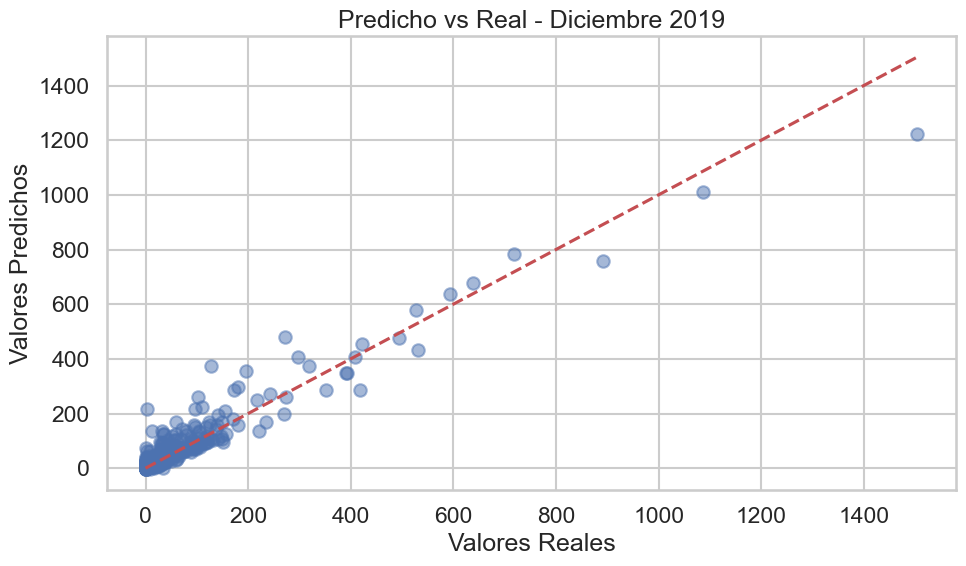

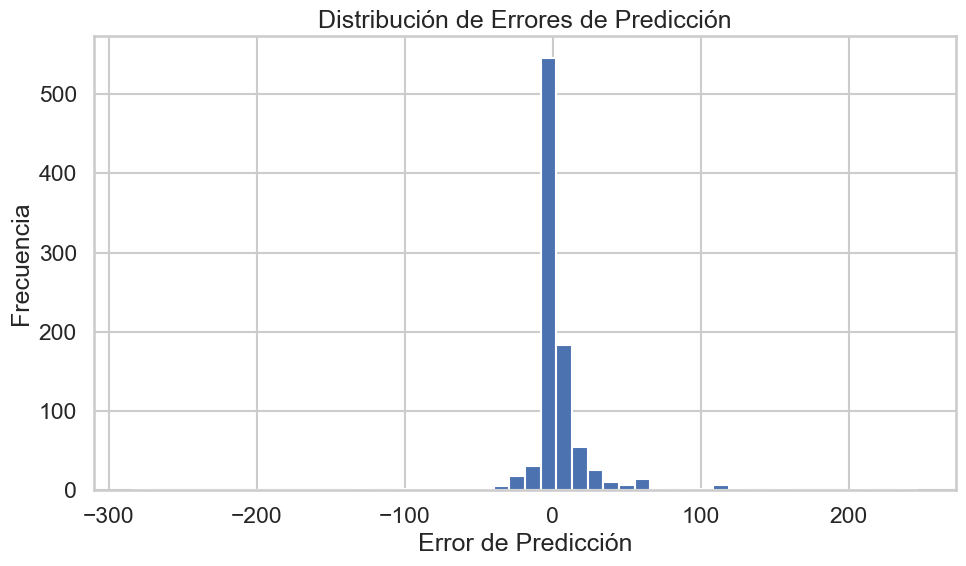

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
import lightgbm as lgb
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Asumiendo que 'data' ya está cargado
data['periodo'] = pd.to_datetime(data['periodo'])

# Filtrar los datos hasta octubre de 2019
data_train = data[data['periodo'] <= '2019-10-31'].copy()

# Definir la fecha objetivo para la predicción
target_date = pd.to_datetime('2019-12-01')

# Crear características adicionales
data_train['year'] = data_train['periodo'].dt.year
data_train['month'] = data_train['periodo'].dt.month
data_train['months_since_start'] = (data_train['periodo'] - data_train['periodo'].min()).dt.days // 30

# Definir las características a utilizar
numeric_features = ['months_since_start', 'year', 'month', 'customer_id', 'sku_size','moving_avg_6m','moving_avg_12m','moving_std_12m','moving_std_6m']
categorical_features = ['product_id', 'cat1', 'cat2', 'cat3', 'brand']
features = numeric_features + categorical_features

# Preparar los conjuntos de entrenamiento y validación
X = data_train[features + ['periodo']]
y = data_train['tn']

# Usar los datos hasta septiembre de 2019 para entrenamiento y octubre de 2019 para validación
train_mask = X['periodo'] < '2019-10-01'
X_train, X_val = X[train_mask], X[~train_mask]
y_train, y_val = y[train_mask], y[~train_mask]

# Eliminar 'periodo' de las características de entrenamiento
X_train = X_train.drop('periodo', axis=1)
X_val = X_val.drop('periodo', axis=1)

print("Forma de X_train:", X_train.shape)
print("Forma de X_val:", X_val.shape)

# Crear preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Crear pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(n_estimators=10000, learning_rate=0.05, num_leaves=31, random_state=42))
])

# Entrenar el modelo
model.fit(X_train, y_train)

# Función para hacer predicciones
def make_predictions(model, data, target_date, products_to_predict, features):
    last_dates = data.groupby('product_id')['periodo'].max().reset_index()
    
    pred_data = []
    for product_id in products_to_predict:
        last_date = last_dates[last_dates['product_id'] == product_id]['periodo'].iloc[0]
        product_data = data[(data['product_id'] == product_id) & (data['periodo'] == last_date)].copy()
        if not product_data.empty:
            product_data['periodo'] = target_date
            product_data['months_since_start'] += (target_date - last_date).days // 30
            product_data['year'] = target_date.year
            product_data['month'] = target_date.month
            pred_data.append(product_data)
    
    pred_data = pd.concat(pred_data, ignore_index=True)
    
    if pred_data.empty:
        print("No hay datos disponibles para la predicción")
        return pd.DataFrame(columns=['product_id', 'tn'])
    
    X_pred = pred_data[features]
    predictions = model.predict(X_pred)
    
    results = pd.DataFrame({
        'product_id': pred_data['product_id'],
        'tn': predictions
    })
    return results

# Obtener la lista de productos a predecir (todos los productos en 201910)
products_to_predict = data_train[data_train['periodo'] == '2019-10-01']['product_id'].unique()

# Hacer predicciones
predictions = make_predictions(model, data_train, target_date, products_to_predict, features)

print("Forma de predictions:", predictions.shape)
print("Primeras filas de predictions:")
print(predictions.head())

# Obtener datos reales de diciembre 2019
real_data_201912 = data[data['periodo'] == '2019-12-01'][['product_id', 'tn']]
real_data_201912 = real_data_201912.rename(columns={'tn': 'tn_real'})

# Combinar predicciones con datos reales
comparison_df = pd.merge(predictions, real_data_201912, on='product_id', how='inner')
comparison_df = comparison_df.rename(columns={'tn': 'tn_predicted'})

# Calcular el error absoluto medio
mae = (comparison_df['tn_predicted'] - comparison_df['tn_real']).abs().mean()

# Calcular el error como la suma de los errores absolutos dividido por la suma de los valores reales
error = (comparison_df['tn_predicted'] - comparison_df['tn_real']).abs().sum() / comparison_df['tn_real'].sum()

print(f"Error (Suma de errores absolutos / Suma de valores reales): {error:.4f}")
print("Error Absoluto Medio:", mae)
print("Muestra de comparación:")
print(comparison_df.head())

# Graficar predicho vs real
plt.figure(figsize=(10, 6))
plt.scatter(comparison_df['tn_real'], comparison_df['tn_predicted'], alpha=0.5)
plt.plot([0, comparison_df['tn_real'].max()], [0, comparison_df['tn_real'].max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Predicho vs Real - Diciembre 2019')
plt.tight_layout()
plt.show()

# Graficar histograma de errores
errors = comparison_df['tn_predicted'] - comparison_df['tn_real']
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50)
plt.xlabel('Error de Predicción')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores de Predicción')
plt.tight_layout()
plt.show()

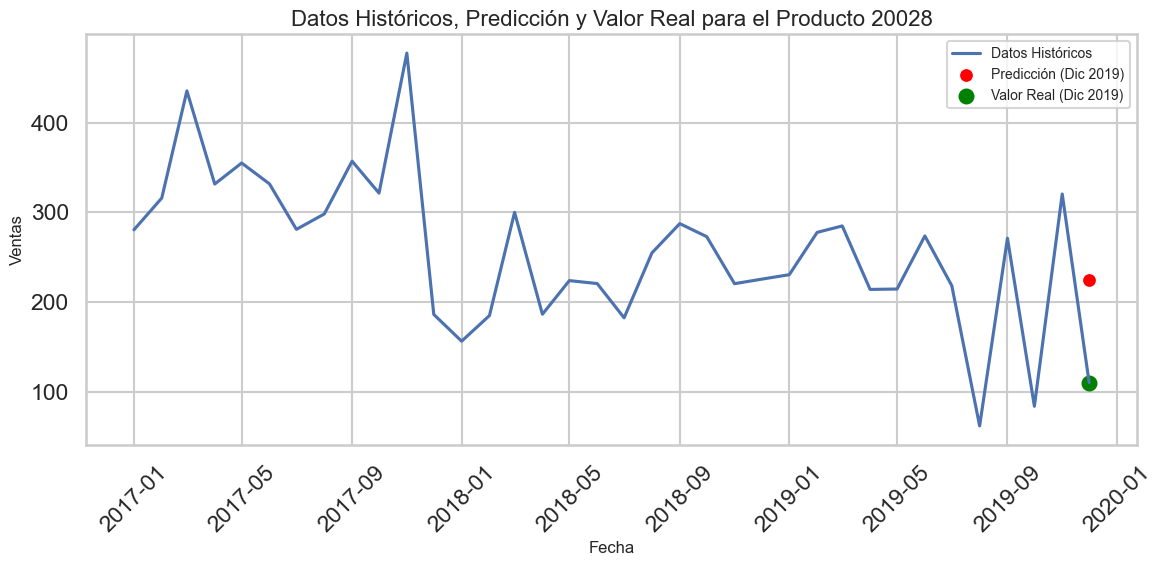

In [102]:
# Elegir un producto específico para visualizar
product_id = 20028    # Puedes cambiar este ID por el de cualquier producto que te interese

# Filtrar datos para el producto seleccionado
product_data = data[data['product_id'] == product_id].copy()
product_forecast = comparison_df[comparison_df['product_id'] == product_id].iloc[0]

# Ordenar datos por fecha
product_data = product_data.sort_values('periodo')

# Crear DataFrame para la predicción
forecast_data = pd.DataFrame({
    'periodo': [target_date],
    'tn': [product_forecast['tn_predicted']]
})

# Configurar el gráfico
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Graficar datos históricos
sns.lineplot(x='periodo', y='tn', data=product_data, label='Datos Históricos')

# Graficar predicción
sns.scatterplot(x='periodo', y='tn', data=forecast_data, label='Predicción (Dic 2019)', color='red', s=100)

# Graficar valor real de diciembre 2019
real_value = product_data[product_data['periodo'] == target_date]['tn'].values[0]
plt.scatter(target_date, real_value, color='green', s=100, label='Valor Real (Dic 2019)')

# Personalizar el gráfico
plt.title(f'Datos Históricos, Predicción y Valor Real para el Producto {product_id}', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Ventas', fontsize=12)
plt.legend(fontsize=10)

# Rotar etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()